In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv('train.csv')

In [3]:
#(1-a)data preprocessing&one-hot encoding
def preprocessing(data):
    data=data.drop(['ID','address','Pstatus','Medu','Fedu','Mjob','Fjob','reason','guardian','traveltime','schoolsup','famsup','nursery','G1','G2','cat'],axis=1)
    data_dum = pd.get_dummies(data)
    data=pd.DataFrame(data_dum)
    #data=data.drop(["school","sex","famsize","paid","activities","higher","internet","romantic"],axis=1)
    return data

In [4]:
data=preprocessing(data)
target=data['G3']
data=data.drop(['G3'],axis=1)

In [5]:
#(1-a) split train.csv into training and validation data 
def train_test_split(x,y,train_percent):
    train_len=int(len(x)*train_percent)
    num_list=[num for num in range(len(x))]
    train_num=random.sample(num_list,train_len)
    X_train=x.iloc[train_num,:]
    Y_train=y[train_num]
    mean=pd.Series();
    std=pd.Series();
    for col in X_train.iloc[:0]:
        mean[col]=np.mean(X_train[col])
        std[col]=np.std(X_train[col])             
    for col in X_train.iloc[:0]:
        X_train[col]=(X_train[col]-mean[col])/std[col]
    test_num=[num for num in range(len(x)) if num not in train_num]
    X_test=x.iloc[test_num,:]
    Y_test=y[test_num]
    for col in X_test.iloc[:0]:
        X_test[col]=(X_test[col]-mean[col])/std[col]
    return X_train,X_test,Y_train,Y_test

In [6]:
X_train,X_test,Y_train,Y_test=train_test_split(data,target,0.8)

/Users/jianchenying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jianchenying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [7]:
#RMSE
def rmse(y_pred,y):
    return np.sqrt(((y_pred-y)**2).mean())

In [8]:
#(1-b)pseudoinverse
weight=np.linalg.pinv(X_train).dot(Y_train)
pred_linear=X_test.dot(weight)
rmse_linear=rmse(pred_linear,Y_test)
print('RMSE=',rmse_linear)

RMSE= 11.544551404691633


In [9]:
def regularization(X,y,lr,_lambda,epochs,bias):
    if(bias==True):
        X = np.c_[np.ones((np.shape(X)[0], 1)), X]
        #X=np.c_[np.random.normal(0,1,len(X)), X]
        w=np.random.randn(np.shape(X)[1],)
    else:
        w=np.random.randn(np.shape(X)[1],)
    for current_iteration in np.arange(epochs):
        y_est=X.dot(w)
        err=y_est-y
        regu_term=(_lambda/2)*w.T.dot(w)
        j_w=((y_est-y)**2).mean()+regu_term
        gradient=(1/np.shape(X)[0])*(X.T.dot(err)+(_lambda*w))
        w=w-lr*gradient
    return w

In [10]:
#(1-c)without bias
w_no_bias=regularization(X_train,Y_train,0.01,1.0,100,bias=False)
y_pred_no_bias=X_test.dot(w_no_bias)
rmse_regu_without_bias=rmse(y_pred_no_bias,Y_test)
print('RMSE=',rmse_regu_without_bias)


RMSE= 11.602993201639904


In [11]:
#(1-d) with bias
w_bias=regularization(X_train,Y_train,0.01,1.0,100,bias=True)
X_test_bias=np.c_[np.ones((X_test.shape[0], 1)), X_test]
y_pred=X_test_bias.dot(w_bias)
rmse_regu_with_bias=rmse(y_pred,Y_test)
print('RMSE=',rmse_regu_with_bias)

RMSE= 4.960280373001535


In [12]:
#(e)Bayesian Linear Regression
def bayesian_regression(X,y,alpha):
    X = np.c_[np.ones((np.shape(X)[0], 1)), X]
    mu_zero=0
    I=np.identity(X.shape[1])
    lambda_m=np.linalg.inv(X.T.dot(X)+np.linalg.inv((1/alpha)*I))
    mu_m=lambda_m.dot(X.T).dot(y)
    return mu_m
    

In [13]:
W_bayesian=bayesian_regression(X_train,Y_train,1.0)
#X_test_bias=np.c_[np.random.normal(0,1,len(X_test)), X_test]
X_test_bias = np.c_[np.ones((np.shape(X_test)[0], 1)), X_test]
pred_bayesian=X_test_bias.dot(W_bayesian)
rmse_bayesian=rmse(pred_bayesian,Y_test)
print('RMSE=',rmse_bayesian)

RMSE= 3.4639853506302596


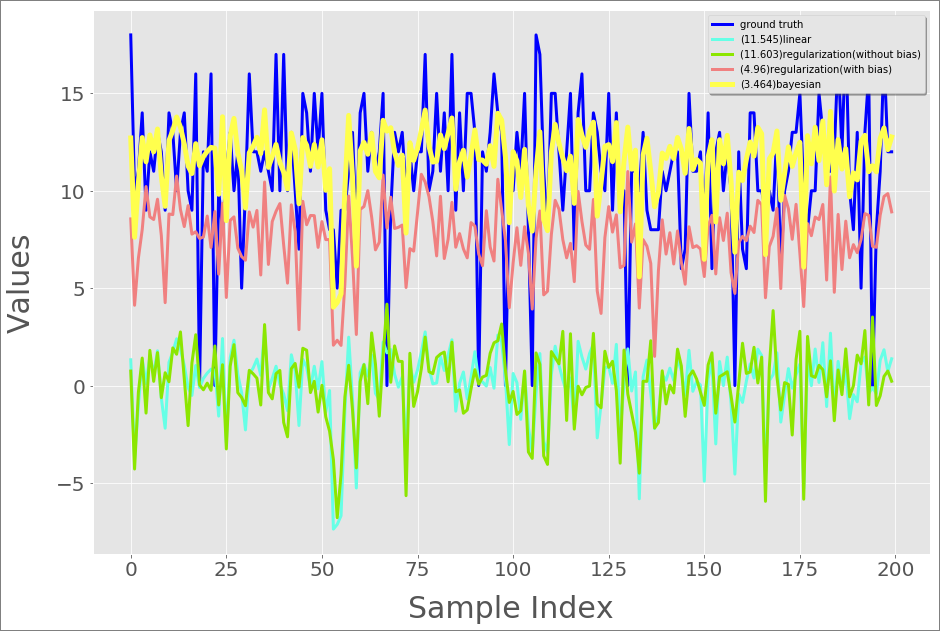

In [14]:
#(f)plot
plt.style.use("ggplot")               
sample_index=[i for i in range(len(Y_test))]
plt.figure(figsize=(15,10),linewidth=2)
plt.plot(sample_index,Y_test,'-',color='blue',label="ground truth",linewidth=3)
plt.plot(sample_index,pred_linear,'-',color='#66FFE6',label=f'({round(rmse_linear,3)})linear',linewidth=3)
plt.plot(sample_index,y_pred_no_bias,'-',color='#8CE600',label=f'({round(rmse_regu_without_bias,3)})regularization(without bias)',linewidth=3)
plt.plot(sample_index,y_pred,'-',color='#F08080',label=f'({round(rmse_regu_with_bias,3)})regularization(with bias)',linewidth=3)
plt.plot(sample_index,pred_bayesian,'-',color='#FFFF4D',label=f'({round(rmse_bayesian,3)})bayesian',linewidth=5)
plt.legend(loc="upper right",shadow=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Sample Index",fontsize=30,labelpad=15)
plt.ylabel("Values",fontsize=30,labelpad=20)
plt.show()

In [15]:
#(g)predict G3 in test_no_G3.csv
test_data=pd.read_csv('test_no_G3.csv')
test_data


,ID,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,cat
0,1001,GP,M,15,U,GT3,T,4,4,services,...,4,3,3,1,1,5,0,14,15,por
1,1002,GP,F,16,U,GT3,T,2,1,other,...,4,5,2,1,1,5,4,9,10,por
2,1003,GP,M,18,U,GT3,T,2,2,other,...,3,3,3,5,5,4,0,12,13,mat
3,1004,GP,F,15,R,GT3,T,2,2,at_home,...,4,3,1,1,1,2,8,14,13,por
4,1005,GP,F,17,R,GT3,T,2,4,at_home,...,4,4,3,1,1,5,0,15,15,por
5,1006,MS,F,16,R,LE3,T,2,2,other,...,4,3,2,1,1,4,0,14,14,por
6,1007,GP,F,16,U,GT3,T,2,2,other,...,5,4,4,1,1,5,0,8,7,mat
7,1008,GP,F,16,U,LE3,T,1,2,other,...,4,4,3,1,1,1,0,13,13,por
8,1009,GP,F,16,U,GT3,T,3,3,other,...,5,3,2,1,1,4,2,13,14,por
9,1010,GP,M,16,U,GT3,T,3,4,other,...,3,4,5,2,4,2,4,9,9,por


In [16]:
test_data=preprocessing(test_data)

In [17]:
for col in test_data.iloc[:0]:
    test_data[col]=(test_data[col]-np.mean(test_data[col]))/np.std(test_data[col])

In [18]:
test_data_bias= np.c_[np.ones((np.shape(test_data)[0], 1)), test_data]
pred_bayesian_test=test_data_bias.dot(W_bayesian)
pred_bayesian_test

array([12.74854505, 11.72052357, 11.42542787, 11.98863994, 12.53991051,
       10.88775839, 10.95147343, 13.76656496, 12.16719793, 10.49798627,
       13.61803395, 10.33381409, 11.78172649, 12.15185289, 11.09568593,
       13.150772  ,  4.03078283, 14.19768597,  7.00352737, 12.58784671,
       12.0353514 ,  9.1367843 , 10.55939494, 12.17779364, 11.51227089,
       11.81631624, 13.71000952, 12.61960179, 11.12364891,  9.5169939 ,
       11.53198677,  6.72525291, 12.47373509, 10.79003447, 12.44546267,
       13.29842752, 11.93180321, 12.63098317, 12.04309093, 13.24081036,
        6.35769474, 12.38754612, 11.01558483, 11.24744832])

In [19]:
output=open('r10725057_1.txt','w')
for i in range(len(test_data)):
    output.write(f'{i}   {pred_bayesian_test[i]} \n')
output.close()

In [20]:
#(2-a)
col_list=['age','workclass','fnlwgt','education','education-num','marital-status','occupation','relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','salary']
data_2=pd.read_csv('adult.data',names=col_list)
data_2

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [21]:
data_2['salary']=data_2['salary'].astype('category')
label = dict(enumerate(data_2['salary'].cat.categories))
data_2['salary']=data_2['salary'].cat.codes

In [22]:
label

{0: ' <=50K', 1: ' >50K'}

In [23]:
target_2=data_2['salary']
data_2=data_2.drop(['salary'],axis=1)
for col in data_2.iloc[:0]:
    if data_2[col].dtype=='object':
        data_2[col]=data_2[col].astype('category').cat.codes

In [24]:
X_train2,X_test2,Y_train2,Y_test2=train_test_split(data_2,target_2,0.8)

/Users/jianchenying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/jianchenying/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
#(2-b)pseudoinverse
weight2=np.linalg.pinv(X_train2).dot(Y_train2)
pred_linear2=X_test2.dot(weight2)
rmse_linear2=rmse(pred_linear2,Y_test2)
print('RMSE=',rmse_linear2)

RMSE= 0.43344069336925173


In [26]:
col_name=[col for col in X_train2.iloc[:0]]
for i in range(X_train2.shape[1]):
    print(f'column-name:{col_name[i]}  weight:{weight2[i]}')

column-name:age  weight:0.06449283809368701
column-name:workclass  weight:-0.0056902388928622835
column-name:fnlwgt  weight:0.00727352321972015
column-name:education  weight:-0.013909679300622316
column-name:education-num  weight:0.1219831624856498
column-name:marital-status  weight:-0.03660912894312229
column-name:occupation  weight:0.00900027678703844
column-name:relationship  weight:-0.024460807764570637
column-name:race  weight:0.01100674708364888
column-name:sex  weight:0.04787053565251115
column-name:capital-gain  weight:0.06780708892142673
column-name:capital-loss  weight:0.04340104901486774
column-name:hours-per-week  weight:0.044523250451339244
column-name:native-country  weight:0.0004974431184608351


In [27]:
#(2-c)regularization without bias
w_no_bias2=regularization(X_train2,Y_train2,0.001,1.0,1000,bias=False)
y_pred_no_bias2=X_test2.dot(w_no_bias2)
rmse_regu_without_bias2=rmse(y_pred_no_bias2,Y_test2)
print('RMSE=',rmse_regu_without_bias2)



RMSE= 1.5268487821661685


In [28]:
#(2-d)regularization with bias
w_bias2=regularization(X_train2,Y_train2,0.001,1.0,1000,bias=True)
X_test_bias2=np.c_[np.ones((np.shape(X_test2)[0], 1)), X_test2]
y_pred2=X_test_bias2.dot(w_bias2)
rmse_regu_with_bias2=rmse(y_pred2,Y_test2)
print('RMSE=',rmse_regu_with_bias2)

RMSE= 1.5001159123189776


In [34]:
#(2-e)bayesian
W_bayesian2=bayesian_regression(X_train2,Y_train2,500)
X_test_bias2=np.c_[np.ones((np.shape(X_test2)[0], 1)), X_test2]
pred_bayesian2=X_test_bias2.dot(W_bayesian2)
rmse_bayesian2=rmse(pred_bayesian2,Y_test2)
print('RMSE=',rmse_bayesian2)

RMSE= 0.36333419188910254


In [35]:
col_name=[col for col in X_train2.iloc[:0]]
for i in range(X_train2.shape[1]):
    print(f'column-name:{col_name[i]}  weight:{W_bayesian2[i]}')


column-name:age  weight:0.23719300888955783
column-name:workclass  weight:0.0634135871885914
column-name:fnlwgt  weight:-0.005382992498676711
column-name:education  weight:0.007005012870089006
column-name:education-num  weight:-0.012736730458593762
column-name:marital-status  weight:0.11942661892252618
column-name:occupation  weight:-0.03642712055207639
column-name:relationship  weight:0.009105764182865655
column-name:race  weight:-0.02529572407792055
column-name:sex  weight:0.010910596541430572
column-name:capital-gain  weight:0.046799886032347825
column-name:capital-loss  weight:0.06689165120757397
column-name:hours-per-week  weight:0.0427987720939181
column-name:native-country  weight:0.044195787509420034


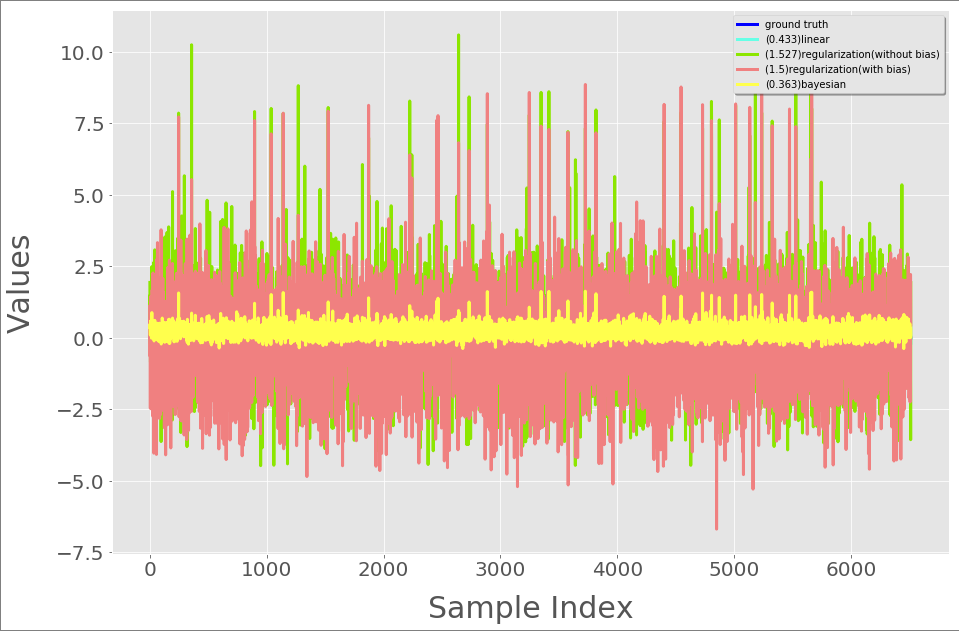

In [36]:
#(f)plot
plt.style.use("ggplot")               
sample_index2=[i for i in range(len(Y_test2))]
plt.figure(figsize=(15,10),linewidth=2)
plt.plot(sample_index2,Y_test2,'-',color='blue',label="ground truth",linewidth=3)
plt.plot(sample_index2,pred_linear2,'-',color='#66FFE6',label=f'({round(rmse_linear2,3)})linear',linewidth=3)
plt.plot(sample_index2,y_pred_no_bias2,'-',color='#8CE600',label=f'({round(rmse_regu_without_bias2,3)})regularization(without bias)',linewidth=3)
plt.plot(sample_index2,y_pred2,'-',color='#F08080',label=f'({round(rmse_regu_with_bias2,3)})regularization(with bias)',linewidth=3)
plt.plot(sample_index2,pred_bayesian2,'-',color='#FFFF4D',label=f'({round(rmse_bayesian2,3)})bayesian',linewidth=3)
plt.legend(loc="upper right",shadow=True)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel("Sample Index",fontsize=30,labelpad=15)
plt.ylabel("Values",fontsize=30,labelpad=20)
plt.show()

In [37]:
test=pd.read_csv('adult.test',names=col_list)
test = test.drop(labels=0, axis=0)
test_y=test['salary'].astype('category').cat.codes
test_x=test.drop(['salary'],axis=1)
for col in test_x.iloc[:0]:
    if test_x[col].dtype=='object':
        test_x[col]=test_x[col].astype('category').cat.codes

In [38]:
for col in test_x.iloc[:0]:
    test_x[col]=(test_x[col]-np.mean(test_x[col]))/np.std(test_x[col])

In [39]:
test_x_bias2=np.c_[np.ones((np.shape(test_x)[0], 1)), test_x]
test_x_bias2.shape
pred_bayesian_test2=test_x_bias2.dot(W_bayesian2)
pred_bayesian_test2

array([-0.00204918,  0.26160192,  0.36960087, ...,  0.48387431,
        0.44704521,  0.47623112])

In [40]:
for i in range(len(pred_bayesian_test2)):
    if pred_bayesian_test2[i]<0.5:
        pred_bayesian_test2[i]=int(0)
    else:pred_bayesian_test2[i]=int(1)

In [41]:
pred=pd.Series(pred_bayesian_test2).astype('int8')

In [42]:
pred

0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        1
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       1
16       0
17       0
18       0
19       1
20       0
21       0
22       0
23       0
24       0
25       1
26       0
27       0
28       0
29       0
        ..
16251    0
16252    1
16253    0
16254    1
16255    1
16256    0
16257    0
16258    0
16259    0
16260    0
16261    1
16262    0
16263    0
16264    0
16265    0
16266    0
16267    0
16268    1
16269    0
16270    0
16271    0
16272    0
16273    0
16274    1
16275    0
16276    0
16277    0
16278    0
16279    0
16280    0
Length: 16281, dtype: int8

In [43]:
test_y

1        0
2        0
3        1
4        1
5        0
6        0
7        0
8        1
9        0
10       0
11       1
12       0
13       0
14       0
15       1
16       1
17       0
18       0
19       0
20       1
21       1
22       0
23       0
24       0
25       0
26       1
27       0
28       0
29       0
30       0
        ..
16252    0
16253    1
16254    0
16255    1
16256    1
16257    0
16258    0
16259    0
16260    0
16261    0
16262    1
16263    0
16264    0
16265    0
16266    1
16267    0
16268    0
16269    0
16270    0
16271    0
16272    0
16273    0
16274    0
16275    0
16276    0
16277    0
16278    0
16279    0
16280    0
16281    1
Length: 16281, dtype: int8

In [44]:
rmse(pred,test_y)

0.5358178208129486

In [46]:
for i,data in enumerate(test_y):
    print(f'{i}  {data} {pred[i]}')

0  0 0
1  0 0
2  1 0
3  1 0
4  0 0
5  0 0
6  0 0
7  1 1
8  0 0
9  0 0
10  1 0
11  0 0
12  0 0
13  0 0
14  1 0
15  1 1
16  0 0
17  0 0
18  0 0
19  1 1
20  1 0
21  0 0
22  0 0
23  0 0
24  0 0
25  1 1
26  0 0
27  0 0
28  0 0
29  0 0
30  1 0
31  0 0
32  0 0
33  0 0
34  0 0
35  0 0
36  1 0
37  0 0
38  0 0
39  0 0
40  1 1
41  1 0
42  0 0
43  0 0
44  0 0
45  1 0
46  0 0
47  0 0
48  0 0
49  0 0
50  0 0
51  0 0
52  0 0
53  1 0
54  0 0
55  0 0
56  0 0
57  1 0
58  1 0
59  0 0
60  0 0
61  0 0
62  0 0
63  0 0
64  0 0
65  0 0
66  1 1
67  0 0
68  0 0
69  0 0
70  1 1
71  0 0
72  0 0
73  0 0
74  0 0
75  0 0
76  0 0
77  0 0
78  0 0
79  0 0
80  0 0
81  0 0
82  0 0
83  1 1
84  0 0
85  0 0
86  0 0
87  1 0
88  0 0
89  1 0
90  0 0
91  0 0
92  1 0
93  0 1
94  0 0
95  0 0
96  0 0
97  0 0
98  1 0
99  0 0
100  0 0
101  0 0
102  0 0
103  0 0
104  0 0
105  0 0
106  0 0
107  0 0
108  0 0
109  0 0
110  0 0
111  0 0
112  1 0
113  0 0
114  0 0
115  0 0
116  0 0
117  0 0
118  0 0
119  1 0
120  0 0
121  0 0
122  0 0
123

1133  0 0
1134  0 0
1135  0 0
1136  0 0
1137  0 0
1138  0 0
1139  0 0
1140  1 1
1141  1 0
1142  0 0
1143  0 0
1144  0 0
1145  0 0
1146  0 0
1147  0 0
1148  0 0
1149  0 0
1150  0 0
1151  1 0
1152  0 0
1153  1 0
1154  1 1
1155  0 0
1156  0 0
1157  1 1
1158  0 1
1159  0 0
1160  0 0
1161  0 0
1162  0 0
1163  0 0
1164  0 0
1165  0 0
1166  0 0
1167  0 0
1168  0 0
1169  1 0
1170  1 1
1171  0 0
1172  0 0
1173  0 0
1174  0 0
1175  0 0
1176  0 0
1177  0 0
1178  0 0
1179  0 0
1180  0 0
1181  1 0
1182  1 1
1183  0 0
1184  1 0
1185  0 0
1186  0 0
1187  1 0
1188  0 0
1189  0 0
1190  1 1
1191  0 0
1192  0 0
1193  0 0
1194  0 0
1195  0 0
1196  0 0
1197  0 0
1198  0 0
1199  1 0
1200  0 0
1201  0 0
1202  1 1
1203  0 0
1204  1 0
1205  0 0
1206  1 0
1207  0 0
1208  0 0
1209  0 0
1210  0 0
1211  1 0
1212  0 1
1213  0 0
1214  1 0
1215  0 0
1216  0 0
1217  0 0
1218  1 0
1219  0 0
1220  0 0
1221  1 0
1222  1 1
1223  0 0
1224  0 0
1225  0 0
1226  1 1
1227  1 1
1228  0 0
1229  1 0
1230  0 0
1231  0 0
1232  0 0


2132  0 0
2133  0 0
2134  1 0
2135  0 0
2136  0 0
2137  0 0
2138  0 0
2139  0 0
2140  0 0
2141  0 0
2142  1 0
2143  0 0
2144  1 1
2145  0 0
2146  0 0
2147  0 0
2148  1 0
2149  0 0
2150  1 0
2151  1 0
2152  0 0
2153  1 1
2154  0 0
2155  0 0
2156  0 0
2157  0 0
2158  0 0
2159  0 0
2160  0 0
2161  0 0
2162  0 0
2163  0 0
2164  0 0
2165  0 0
2166  0 0
2167  1 1
2168  1 1
2169  1 0
2170  0 0
2171  1 0
2172  1 0
2173  0 0
2174  0 0
2175  0 0
2176  0 0
2177  0 0
2178  0 0
2179  0 0
2180  0 0
2181  1 0
2182  0 0
2183  1 0
2184  0 0
2185  0 0
2186  1 0
2187  0 0
2188  0 0
2189  1 1
2190  0 0
2191  0 0
2192  0 0
2193  0 0
2194  0 0
2195  0 0
2196  0 0
2197  1 0
2198  0 0
2199  1 0
2200  1 0
2201  0 0
2202  1 1
2203  0 0
2204  0 0
2205  0 0
2206  0 0
2207  0 0
2208  0 0
2209  0 0
2210  0 0
2211  0 0
2212  0 0
2213  0 0
2214  0 0
2215  0 0
2216  1 1
2217  0 0
2218  1 0
2219  0 0
2220  1 1
2221  0 0
2222  1 1
2223  0 0
2224  0 0
2225  1 0
2226  0 0
2227  0 0
2228  0 0
2229  0 0
2230  0 0
2231  0 0


3132  0 0
3133  0 0
3134  1 1
3135  0 0
3136  0 0
3137  0 0
3138  0 0
3139  0 0
3140  0 0
3141  1 0
3142  0 0
3143  0 0
3144  0 0
3145  0 0
3146  0 0
3147  1 0
3148  0 0
3149  0 0
3150  0 0
3151  1 0
3152  0 0
3153  0 0
3154  1 1
3155  0 0
3156  0 0
3157  0 0
3158  1 0
3159  0 0
3160  1 1
3161  0 1
3162  1 0
3163  1 0
3164  0 0
3165  0 0
3166  0 0
3167  0 0
3168  0 0
3169  0 0
3170  0 1
3171  0 0
3172  0 0
3173  1 1
3174  0 0
3175  0 0
3176  1 0
3177  0 0
3178  1 0
3179  0 0
3180  0 0
3181  0 0
3182  0 0
3183  0 0
3184  0 0
3185  0 0
3186  0 0
3187  1 0
3188  0 0
3189  1 1
3190  0 0
3191  1 1
3192  0 0
3193  0 0
3194  1 0
3195  0 0
3196  0 0
3197  0 0
3198  0 0
3199  0 0
3200  0 0
3201  0 0
3202  0 0
3203  0 0
3204  0 0
3205  1 0
3206  0 0
3207  0 0
3208  0 0
3209  0 0
3210  0 0
3211  0 0
3212  0 0
3213  0 0
3214  0 0
3215  0 0
3216  0 0
3217  0 0
3218  0 0
3219  0 0
3220  0 0
3221  1 0
3222  0 1
3223  0 0
3224  0 0
3225  0 0
3226  0 0
3227  0 1
3228  0 0
3229  0 0
3230  0 0
3231  0 0


4131  0 0
4132  0 0
4133  0 0
4134  1 0
4135  0 0
4136  0 0
4137  1 0
4138  1 0
4139  0 0
4140  0 0
4141  0 0
4142  0 0
4143  0 0
4144  0 0
4145  0 0
4146  0 0
4147  0 0
4148  0 0
4149  0 0
4150  1 1
4151  0 0
4152  0 0
4153  0 0
4154  1 0
4155  0 0
4156  0 0
4157  0 0
4158  0 0
4159  1 0
4160  1 1
4161  1 0
4162  0 0
4163  1 1
4164  0 0
4165  0 0
4166  1 1
4167  0 0
4168  0 0
4169  0 0
4170  0 0
4171  0 0
4172  0 0
4173  1 1
4174  0 0
4175  0 0
4176  0 0
4177  0 1
4178  0 0
4179  0 0
4180  0 0
4181  0 0
4182  0 0
4183  0 0
4184  1 0
4185  0 0
4186  0 1
4187  0 0
4188  0 0
4189  0 0
4190  0 0
4191  0 0
4192  1 0
4193  0 0
4194  0 0
4195  0 0
4196  0 0
4197  0 0
4198  0 0
4199  0 0
4200  0 0
4201  1 1
4202  1 1
4203  0 0
4204  0 0
4205  1 0
4206  0 0
4207  0 0
4208  1 0
4209  0 0
4210  1 0
4211  1 1
4212  0 0
4213  0 1
4214  0 0
4215  0 0
4216  0 0
4217  0 0
4218  0 0
4219  1 0
4220  0 0
4221  0 0
4222  0 0
4223  0 0
4224  0 1
4225  0 0
4226  0 0
4227  0 0
4228  0 0
4229  0 0
4230  0 0


5630  0 0
5631  0 0
5632  0 0
5633  0 0
5634  0 0
5635  0 0
5636  1 1
5637  1 0
5638  1 0
5639  0 0
5640  0 0
5641  0 0
5642  0 0
5643  0 0
5644  0 0
5645  1 0
5646  0 0
5647  0 0
5648  0 0
5649  0 0
5650  0 0
5651  0 0
5652  1 0
5653  0 0
5654  0 0
5655  0 0
5656  0 0
5657  0 0
5658  0 0
5659  1 0
5660  0 0
5661  0 0
5662  0 0
5663  1 0
5664  0 1
5665  0 0
5666  0 0
5667  0 0
5668  0 0
5669  0 0
5670  0 0
5671  1 0
5672  0 0
5673  0 0
5674  1 1
5675  0 0
5676  0 0
5677  0 0
5678  0 0
5679  0 0
5680  1 1
5681  0 0
5682  0 0
5683  0 0
5684  1 0
5685  0 0
5686  0 0
5687  0 0
5688  0 0
5689  0 0
5690  0 0
5691  1 0
5692  1 0
5693  0 0
5694  0 0
5695  0 0
5696  0 0
5697  0 0
5698  0 0
5699  0 0
5700  0 0
5701  0 0
5702  1 0
5703  0 0
5704  0 0
5705  1 1
5706  0 0
5707  0 0
5708  0 0
5709  0 0
5710  0 0
5711  1 0
5712  0 1
5713  0 0
5714  0 0
5715  0 0
5716  0 0
5717  1 0
5718  0 0
5719  1 0
5720  0 0
5721  0 0
5722  1 1
5723  0 1
5724  0 0
5725  0 0
5726  0 0
5727  0 0
5728  1 1
5729  0 0


7117  1 0
7118  0 0
7119  0 0
7120  0 0
7121  0 0
7122  0 0
7123  1 1
7124  0 0
7125  0 0
7126  1 1
7127  0 0
7128  0 0
7129  0 0
7130  1 0
7131  0 0
7132  0 0
7133  0 0
7134  0 0
7135  0 0
7136  0 0
7137  0 0
7138  0 0
7139  0 0
7140  0 0
7141  0 0
7142  0 0
7143  0 0
7144  1 0
7145  0 0
7146  1 1
7147  0 0
7148  0 0
7149  0 0
7150  0 0
7151  0 0
7152  0 0
7153  0 0
7154  0 0
7155  0 0
7156  0 0
7157  1 0
7158  0 0
7159  1 1
7160  0 0
7161  1 1
7162  0 1
7163  0 0
7164  0 0
7165  0 0
7166  0 0
7167  0 0
7168  1 0
7169  1 1
7170  0 0
7171  0 0
7172  0 0
7173  0 0
7174  1 0
7175  1 0
7176  0 1
7177  0 0
7178  0 0
7179  0 0
7180  0 0
7181  0 0
7182  0 0
7183  0 0
7184  0 0
7185  1 0
7186  0 0
7187  1 0
7188  0 0
7189  0 0
7190  0 0
7191  0 0
7192  0 0
7193  0 0
7194  0 0
7195  0 0
7196  0 0
7197  0 0
7198  0 0
7199  0 0
7200  0 0
7201  0 0
7202  0 0
7203  0 0
7204  0 0
7205  0 0
7206  0 1
7207  0 0
7208  0 0
7209  0 0
7210  0 0
7211  1 0
7212  0 0
7213  0 0
7214  0 0
7215  0 0
7216  0 0


8129  0 0
8130  1 1
8131  0 0
8132  0 0
8133  0 0
8134  0 0
8135  0 0
8136  0 0
8137  0 0
8138  0 0
8139  1 0
8140  0 0
8141  0 0
8142  0 0
8143  0 0
8144  1 1
8145  0 0
8146  1 0
8147  1 0
8148  0 0
8149  0 0
8150  0 0
8151  0 0
8152  0 0
8153  0 0
8154  0 0
8155  0 0
8156  1 0
8157  1 0
8158  0 0
8159  0 0
8160  0 0
8161  0 0
8162  0 0
8163  0 0
8164  0 0
8165  0 0
8166  1 0
8167  1 0
8168  1 0
8169  0 0
8170  0 0
8171  0 0
8172  0 0
8173  1 1
8174  0 0
8175  1 0
8176  0 0
8177  0 0
8178  0 0
8179  0 0
8180  0 0
8181  0 0
8182  1 0
8183  1 0
8184  1 0
8185  0 0
8186  0 0
8187  1 1
8188  0 1
8189  0 0
8190  0 0
8191  0 0
8192  0 0
8193  0 0
8194  0 0
8195  1 0
8196  0 0
8197  0 0
8198  0 0
8199  0 0
8200  0 0
8201  0 0
8202  0 0
8203  0 0
8204  0 0
8205  0 0
8206  0 0
8207  0 0
8208  0 1
8209  0 0
8210  0 0
8211  1 0
8212  0 0
8213  0 0
8214  1 0
8215  1 1
8216  0 0
8217  0 0
8218  0 0
8219  0 0
8220  0 0
8221  1 1
8222  0 0
8223  0 0
8224  0 0
8225  0 0
8226  0 0
8227  0 0
8228  0 0


9128  0 0
9129  1 0
9130  0 0
9131  1 0
9132  0 0
9133  0 0
9134  0 0
9135  0 0
9136  0 1
9137  0 0
9138  1 1
9139  0 0
9140  0 0
9141  0 0
9142  0 0
9143  0 0
9144  0 0
9145  0 0
9146  0 0
9147  0 0
9148  0 1
9149  0 0
9150  0 0
9151  0 0
9152  0 0
9153  0 0
9154  1 0
9155  0 0
9156  0 0
9157  0 0
9158  1 1
9159  0 0
9160  0 0
9161  0 0
9162  0 0
9163  0 0
9164  0 0
9165  0 0
9166  0 0
9167  1 0
9168  0 0
9169  0 0
9170  1 1
9171  1 1
9172  0 0
9173  0 0
9174  0 0
9175  0 0
9176  0 0
9177  0 1
9178  0 0
9179  0 0
9180  0 0
9181  0 0
9182  0 0
9183  0 0
9184  0 0
9185  1 1
9186  1 0
9187  1 0
9188  0 0
9189  1 0
9190  0 0
9191  0 0
9192  1 0
9193  1 0
9194  0 1
9195  0 0
9196  0 0
9197  0 0
9198  0 0
9199  1 0
9200  1 1
9201  0 0
9202  1 0
9203  0 0
9204  0 0
9205  1 1
9206  1 0
9207  0 0
9208  1 1
9209  0 0
9210  1 0
9211  0 0
9212  0 0
9213  0 0
9214  1 0
9215  0 0
9216  1 0
9217  0 0
9218  0 0
9219  0 0
9220  0 0
9221  0 0
9222  0 0
9223  0 0
9224  1 0
9225  0 0
9226  0 0
9227  1 0


10128  1 0
10129  0 1
10130  0 0
10131  0 0
10132  0 0
10133  1 1
10134  0 0
10135  0 0
10136  0 0
10137  1 0
10138  0 1
10139  0 0
10140  0 0
10141  0 0
10142  1 1
10143  0 1
10144  0 0
10145  1 0
10146  0 0
10147  0 0
10148  0 0
10149  0 0
10150  0 0
10151  0 0
10152  1 0
10153  0 0
10154  0 0
10155  1 1
10156  0 1
10157  0 0
10158  0 0
10159  0 0
10160  0 0
10161  0 0
10162  0 0
10163  0 0
10164  0 0
10165  0 0
10166  0 0
10167  1 0
10168  0 0
10169  0 0
10170  0 0
10171  0 0
10172  0 0
10173  0 0
10174  1 0
10175  1 0
10176  0 0
10177  0 0
10178  0 0
10179  0 0
10180  0 0
10181  1 1
10182  0 0
10183  1 0
10184  0 0
10185  1 0
10186  0 0
10187  1 0
10188  0 0
10189  0 0
10190  0 0
10191  0 0
10192  0 0
10193  0 0
10194  1 1
10195  0 0
10196  0 0
10197  0 0
10198  0 0
10199  0 0
10200  0 0
10201  0 0
10202  0 0
10203  0 0
10204  0 0
10205  0 0
10206  0 0
10207  1 1
10208  0 1
10209  0 0
10210  0 0
10211  0 0
10212  0 0
10213  1 0
10214  0 0
10215  0 0
10216  0 0
10217  0 0
10218  0 0

11127  0 0
11128  0 1
11129  0 0
11130  0 0
11131  1 1
11132  0 0
11133  1 0
11134  0 0
11135  0 0
11136  0 0
11137  0 0
11138  0 0
11139  0 0
11140  0 0
11141  0 0
11142  0 0
11143  1 1
11144  1 0
11145  0 0
11146  1 1
11147  1 0
11148  0 0
11149  1 1
11150  0 0
11151  0 0
11152  1 0
11153  0 0
11154  0 0
11155  1 1
11156  0 0
11157  0 0
11158  0 0
11159  0 0
11160  0 0
11161  1 1
11162  0 0
11163  1 1
11164  0 0
11165  1 1
11166  1 1
11167  0 0
11168  0 0
11169  0 0
11170  0 0
11171  0 0
11172  0 0
11173  0 0
11174  1 0
11175  0 0
11176  0 0
11177  1 0
11178  0 0
11179  0 0
11180  0 0
11181  0 0
11182  1 0
11183  0 0
11184  0 0
11185  0 0
11186  0 0
11187  0 0
11188  1 0
11189  0 0
11190  0 0
11191  0 0
11192  1 1
11193  0 1
11194  0 0
11195  1 1
11196  0 1
11197  0 0
11198  0 0
11199  1 0
11200  0 0
11201  0 0
11202  0 0
11203  0 0
11204  0 0
11205  1 0
11206  0 0
11207  0 0
11208  0 0
11209  0 0
11210  0 0
11211  0 0
11212  0 0
11213  0 0
11214  0 0
11215  0 0
11216  1 0
11217  0 0

12127  1 1
12128  0 0
12129  0 0
12130  0 0
12131  0 0
12132  0 0
12133  1 0
12134  0 0
12135  0 0
12136  1 1
12137  0 0
12138  1 0
12139  1 0
12140  0 0
12141  0 0
12142  0 0
12143  1 0
12144  0 0
12145  0 0
12146  0 0
12147  1 0
12148  0 0
12149  0 0
12150  0 0
12151  1 0
12152  1 0
12153  0 0
12154  1 0
12155  0 0
12156  0 0
12157  1 0
12158  0 0
12159  1 1
12160  0 0
12161  0 0
12162  0 0
12163  0 0
12164  0 0
12165  0 0
12166  1 0
12167  0 0
12168  0 0
12169  0 0
12170  0 0
12171  0 0
12172  1 0
12173  0 0
12174  1 0
12175  0 0
12176  0 0
12177  0 0
12178  0 0
12179  0 0
12180  0 0
12181  0 0
12182  0 0
12183  0 0
12184  0 0
12185  0 0
12186  0 0
12187  0 0
12188  0 0
12189  0 0
12190  0 0
12191  0 0
12192  1 0
12193  0 0
12194  0 0
12195  0 0
12196  1 0
12197  0 0
12198  1 0
12199  0 0
12200  0 0
12201  0 0
12202  0 0
12203  0 0
12204  0 0
12205  0 0
12206  0 0
12207  0 1
12208  0 0
12209  1 0
12210  0 0
12211  1 0
12212  0 0
12213  0 0
12214  0 0
12215  1 0
12216  0 0
12217  1 0

13126  1 0
13127  0 0
13128  0 0
13129  0 0
13130  0 0
13131  0 0
13132  0 0
13133  0 0
13134  0 0
13135  0 0
13136  0 0
13137  0 0
13138  0 0
13139  1 0
13140  0 0
13141  0 0
13142  0 0
13143  0 0
13144  1 0
13145  0 1
13146  0 0
13147  0 0
13148  1 1
13149  1 0
13150  0 1
13151  1 0
13152  0 0
13153  0 0
13154  0 0
13155  0 0
13156  0 1
13157  1 0
13158  0 0
13159  0 0
13160  0 0
13161  1 1
13162  0 0
13163  0 0
13164  0 0
13165  1 1
13166  0 0
13167  0 0
13168  0 0
13169  0 0
13170  0 0
13171  0 0
13172  0 0
13173  0 0
13174  0 0
13175  1 0
13176  1 0
13177  0 0
13178  1 1
13179  0 0
13180  0 0
13181  1 0
13182  0 0
13183  0 0
13184  1 0
13185  1 1
13186  0 0
13187  0 1
13188  0 0
13189  0 0
13190  0 0
13191  1 0
13192  1 0
13193  0 0
13194  1 0
13195  0 0
13196  0 0
13197  0 0
13198  0 0
13199  1 0
13200  0 0
13201  0 0
13202  0 0
13203  0 0
13204  1 0
13205  0 0
13206  1 0
13207  0 0
13208  0 0
13209  1 0
13210  0 0
13211  0 1
13212  0 0
13213  1 0
13214  0 0
13215  0 0
13216  1 0

14126  0 0
14127  0 0
14128  0 0
14129  1 0
14130  0 0
14131  0 0
14132  0 0
14133  1 0
14134  0 0
14135  1 0
14136  0 0
14137  1 0
14138  1 0
14139  0 1
14140  0 0
14141  1 1
14142  1 0
14143  1 0
14144  1 0
14145  0 0
14146  1 0
14147  0 0
14148  1 0
14149  1 1
14150  0 0
14151  0 0
14152  1 0
14153  0 0
14154  1 0
14155  0 0
14156  0 0
14157  1 0
14158  0 0
14159  1 1
14160  0 0
14161  0 0
14162  0 0
14163  0 0
14164  0 0
14165  0 0
14166  0 0
14167  0 0
14168  0 0
14169  0 0
14170  0 0
14171  0 0
14172  0 0
14173  0 0
14174  1 0
14175  1 1
14176  0 0
14177  0 0
14178  0 0
14179  1 0
14180  0 0
14181  1 1
14182  0 0
14183  0 0
14184  1 1
14185  1 0
14186  1 1
14187  0 0
14188  1 0
14189  0 0
14190  1 0
14191  1 0
14192  0 0
14193  1 1
14194  0 0
14195  0 0
14196  0 0
14197  0 0
14198  0 0
14199  0 0
14200  0 0
14201  1 1
14202  0 0
14203  0 0
14204  1 0
14205  0 1
14206  0 0
14207  0 0
14208  0 0
14209  1 0
14210  1 1
14211  0 0
14212  0 0
14213  0 0
14214  0 0
14215  0 0
14216  0 0

15125  0 0
15126  1 0
15127  0 0
15128  0 0
15129  0 0
15130  0 0
15131  0 0
15132  0 0
15133  0 0
15134  0 0
15135  0 1
15136  0 1
15137  1 0
15138  1 0
15139  0 0
15140  0 0
15141  0 0
15142  0 1
15143  0 0
15144  0 0
15145  1 0
15146  0 0
15147  0 0
15148  1 1
15149  0 0
15150  0 0
15151  1 1
15152  0 0
15153  0 0
15154  1 0
15155  0 0
15156  0 0
15157  0 1
15158  0 0
15159  0 0
15160  0 1
15161  0 0
15162  1 1
15163  0 0
15164  0 0
15165  1 0
15166  0 0
15167  0 0
15168  0 0
15169  0 0
15170  0 0
15171  0 0
15172  0 0
15173  0 1
15174  0 0
15175  0 0
15176  1 0
15177  0 0
15178  1 1
15179  0 0
15180  0 0
15181  0 0
15182  0 0
15183  0 0
15184  1 1
15185  0 0
15186  0 0
15187  0 0
15188  0 0
15189  0 0
15190  1 1
15191  1 0
15192  0 0
15193  0 0
15194  0 0
15195  0 0
15196  0 0
15197  0 0
15198  0 0
15199  0 0
15200  0 0
15201  0 0
15202  1 0
15203  0 0
15204  0 0
15205  0 0
15206  1 1
15207  0 0
15208  0 0
15209  0 0
15210  0 0
15211  0 1
15212  1 0
15213  1 1
15214  0 0
15215  0 0

16125  0 0
16126  0 0
16127  0 0
16128  0 0
16129  0 0
16130  0 0
16131  0 0
16132  0 0
16133  0 0
16134  1 1
16135  0 0
16136  0 0
16137  0 0
16138  0 0
16139  0 0
16140  1 0
16141  0 0
16142  0 0
16143  0 0
16144  0 0
16145  0 0
16146  0 0
16147  0 0
16148  0 0
16149  0 0
16150  0 0
16151  0 0
16152  0 0
16153  1 0
16154  0 0
16155  1 1
16156  1 0
16157  1 0
16158  1 1
16159  0 1
16160  0 0
16161  1 0
16162  1 1
16163  0 0
16164  0 0
16165  1 1
16166  0 0
16167  0 0
16168  0 0
16169  0 0
16170  0 0
16171  0 0
16172  0 0
16173  0 0
16174  1 1
16175  1 1
16176  0 0
16177  0 0
16178  0 0
16179  1 0
16180  1 0
16181  1 0
16182  0 0
16183  0 0
16184  1 1
16185  1 1
16186  0 0
16187  0 0
16188  0 0
16189  0 0
16190  0 0
16191  0 0
16192  0 0
16193  0 0
16194  1 0
16195  0 0
16196  0 0
16197  0 0
16198  0 0
16199  0 0
16200  0 0
16201  0 1
16202  0 0
16203  0 0
16204  0 0
16205  1 0
16206  0 0
16207  0 0
16208  0 0
16209  1 0
16210  0 0
16211  0 0
16212  0 0
16213  0 0
16214  0 0
16215  1 0

In [55]:
correct_index=[]
for i,data in enumerate(test_y):
    if data==pred[i]:
        correct_index.append(i)

In [56]:
print('correction rate:',len(correct_index)/len(test))

correction rate: 0.8089183711074258
